In [64]:
### I want to match the resolution of a wise image with an irac image ###

    # vocab: convolution is the process of adding each element of the image to its local neighbors, weighted by the kernel
    # vocab: in image processing, a kernel is simply a small matrix used for blurring, sharpening, embossing, edge detection, and more
    ### note: because I can't figure out how to construct the proper kernel to do resolution matching (photutils.psf.matching and PyPHER are both supposedly able to do this, but I can't get them to work), in the meantime I decided simply to convolve images with generic kernels

In [65]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel # convolve is better for small kernels, convolve_fft much more efficient for larger kernels (they're otherwise interchangeable); Gaussian2DKernel seems to be the standard for blurring images
import numpy as np

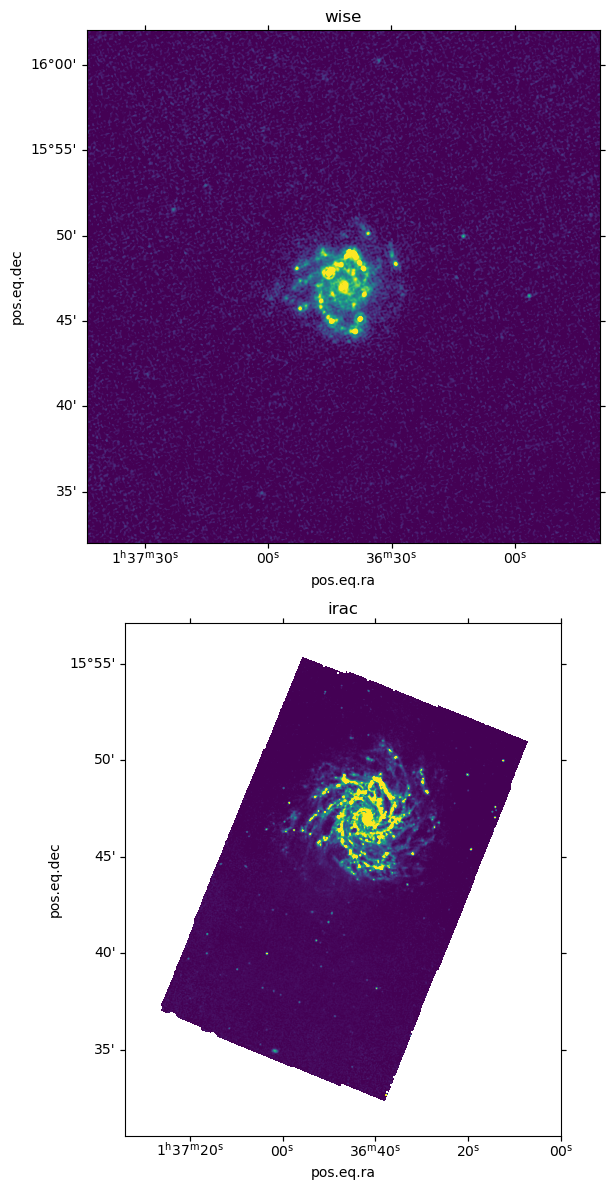

In [66]:
# I decided to use a wise image and an irac image
wise = fits.open('/Users/michaelhill/Downloads/raw_background_comps/ngc0628_w4_mjysr.fits')[0]
irac = fits.open('/Users/michaelhill/Downloads/raw_background_comps/ngc0628_irac4_gauss4.fits')[0]

wcs_wise = WCS(wise.header)
wcs_irac = WCS(irac.header)

plt.figure(figsize=(12,12))

wise_ax = plt.subplot(2,1,1, projection=wcs_wise)
wise_ax = plt.imshow(wise.data, origin='lower', vmin=-1e-4, vmax=3) # origin='lower' makes the (0,0) point the lower left corner instead of the upper right corner (it defaults to this if using WCS, but if we aren't then our images will be flipped diagonally if we don't specify origin='lower')
wise_ax = plt.title('wise')

irac_ax = plt.subplot(2,1,2, projection=wcs_irac)
irac_ax = plt.imshow(irac.data, vmin=-1e-4, vmax=3)
wisea_ax = plt.title('irac')

plt.tight_layout() # should only be executed after all data is added, otherwise it doesn't work (makes spacing between subplots nice)
plt.show()

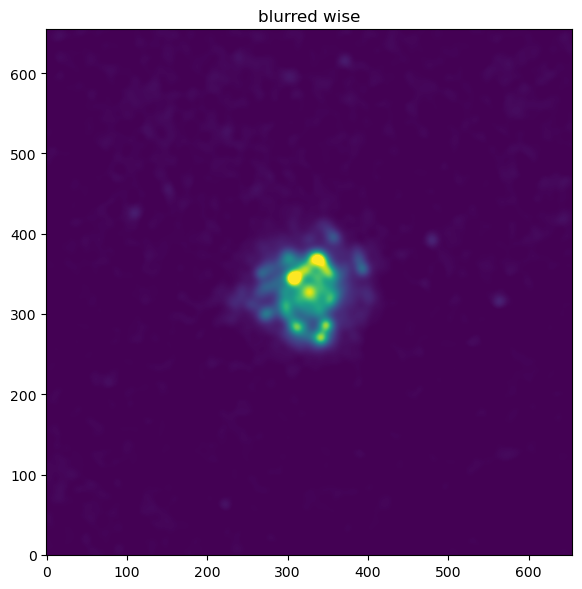

In [67]:
### I'm just gonna make an example of convolution using the Gaussian2DKernel
### the actual kernel I should use to resolution match images is what I still have to figure out

kernel = Gaussian2DKernel(5) # increase input for more blurring
wise_conv = convolve_fft(wise.data, kernel) # for low inputs to Gaussian2DKernel, convolve_fft is not necessary (convolve works fine)

plt.figure(figsize=(6,6))
plt.imshow(wise_conv, origin='lower', vmin=-1e-4, vmax=3)
plt.title('blurred wise')
plt.tight_layout()
plt.show()

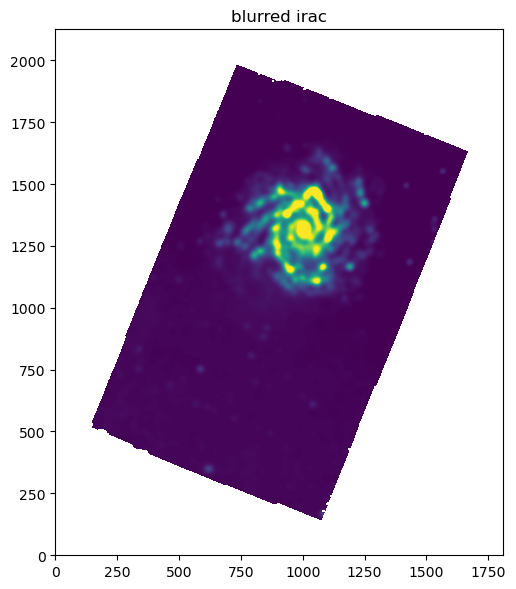

In [68]:
kernel = Gaussian2DKernel(10) # increase input for more "blurring"
irac_conv = convolve_fft(irac.data, kernel, nan_treatment='fill', fill_value=0) # using convolve_fft because takes very long time otherwise (I'm not sure why this isn't the case for wise)
# setting nan_treatment to 'fill' (instead of default of 'interpolate') because otherwise it gets messed up; doesn't let me set the NaN values to NaN; setting to a number other than 0 results in data getting lost at edges of image

### these next few lines are going back and setting all values that were originally NaN back to NaN (instead of fill_value)
irac_masked = np.ma.masked_invalid(irac.data) # function returns array with all non-real values (like NaN) masked out
irac_conv = np.ma.masked_array(irac_conv, mask=irac_masked.mask) # applying mask we just created from original image to blurred image

plt.figure(figsize=(6,6))
plt.imshow(irac_conv, origin='lower', vmin=-1e-4, vmax=3)
plt.title('blurred irac')
plt.tight_layout()
plt.show()

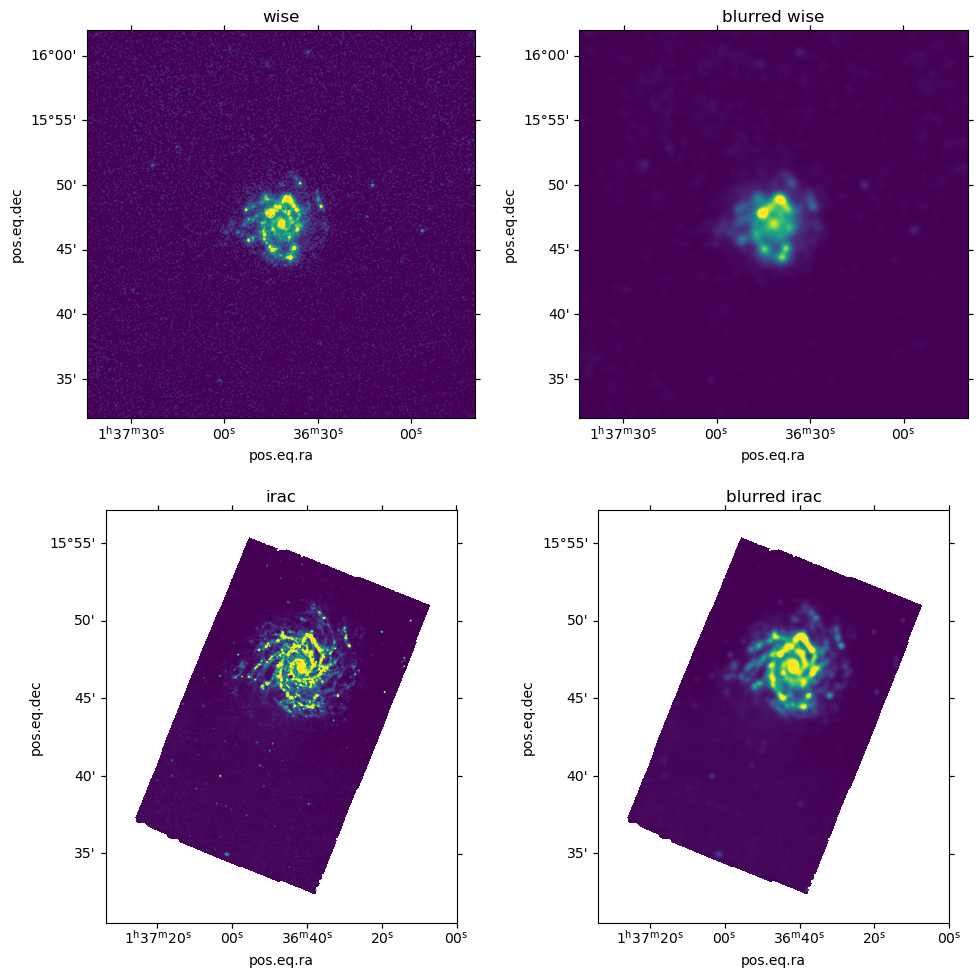

In [69]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1, projection=wcs_wise)
wise_ax = plt.imshow(wise.data, origin='lower', vmin=-1e-4, vmax=3)
wise_ax = plt.title('wise')

plt.subplot(2,2,2, projection=wcs_wise)
wise_conv_ax = plt.imshow(wise_conv, origin='lower', vmin=-1e-4, vmax=3)
wise_conv_ax = plt.title('blurred wise')

plt.subplot(2,2,3, projection=wcs_irac)
irac_ax = plt.imshow(irac.data, origin='lower', vmin=-1e-4, vmax=3)
irac_ax = plt.title('irac')

plt.subplot(2,2,4, projection=wcs_irac)
irac_conv_ax = plt.imshow(irac_conv, origin='lower', vmin=-1e-4, vmax=3)
irac_conv_ax = plt.title('blurred irac')

plt.tight_layout()
plt.show()